In [ ]:
'''
导入实验所需的库
    1、深度学习框架torch
    2、用于数据集加载的datasets
    3、用于数据预处理的transforms
    4、数据集下载器DataLoader
    5、numpy和matplotlib
'''
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
'''
数据预处理
    1、将图片转换成PyTorch中处理的对象Tensor,并且进行标准化
    2、做归一化：RBG三通道的均值为：(0.4914, 0.4822,0.4465), RGB三通道的标准差为(0.2023, 0.1994, 0.2010)
'''
data_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822,0.4465), (0.2023, 0.1994, 0.2010))
])

In [ ]:
'''
读取数据并构成数据集
    1、读取cifar10数据集，形成训练集和测试集
    2、将读取到的训练集和测试集构成批次，批次大小为64，且打乱数据顺序
'''
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=data_tf)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=data_tf)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

deer


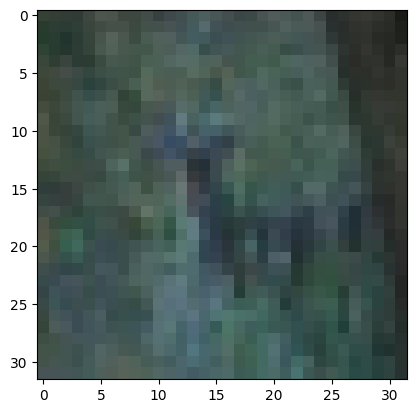

In [ ]:
'''
可视化数据
    1、选取训练集中索引为10的图片
    2、输出索引为10的图片的标签(英文名称)
    3、将RGB三个通道合成一张图片
    4、利用matplotlib可视化合成的图片
'''
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'fog', 'horse', 'ship', 'truck']

data, label = train_dataset[10]
print(class_names[label])

B = data.numpy()[0,:,:] * 0.2023 + 0.4914
G = data.numpy()[1,:,:] * 0.1994 + 0.4822
R = data.numpy()[2,:,:] * 0.2010 + 0.4465

RGB = np.stack((R, G, B), axis=-1)
plt.imshow(RGB)

In [ ]:
'''
构建模型
    1、BaseNet继承toch中所有神经网络的父类
    2、构建三层网络结构，激活函数为relu
    3、实现网络的前向传播
'''
class BaseNet(torch.nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        '''
        in_dim：输入神经元个数
        n_hidden_1：第一层隐藏层神经元个数
        n_hidden_2：第二层隐藏层神经元个数
        out_dim：输出层神经元个数
        '''
        super(BaseNet, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(in_dim, n_hidden_1),
            torch.nn.ReLU()
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(n_hidden_1, n_hidden_2),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Linear(n_hidden_2, out_dim)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [ ]:
'''
创建网络模型
    1、第一层隐藏层神经元个数为500
    2、第二层隐藏层神经元个数为200
'''
model = BaseNet(3072, 500, 200, 10)

In [ ]:
'''
模型配置
    1、定义损失函数为交叉熵损失函数
    2、定义优化器为SGD，学习率为0.02
'''
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

In [ ]:
'''
训练模型
    1、定义训练迭代轮数epochs为20
    2、定义统计损失值的列表
    3、遍历数据集，得到每个batch的数据
    4、得到每个batch的特征值和目标值
    5、将输入图像数据展平
    6、得到预测结果
    7、计算损失值
    8、梯度清零
    9、反向传播
    10、更新参数
'''
epochs = 20

for epoch in range(epochs):

    loss_list = []

    for data in train_loader:

        img, label = data

        # 判断使用可以用GPU训练
        if torch.cuda.is_available():
            img = img.cuda()
            label = label.cuda()
            model.cuda()

        img = img.view(img.size(0), -1)

        out = model(img)

        loss = criterion(out,label)

        loss_list.append(loss.item())

        # 梯度清零
        optimizer.zero_grad()

        # 误差反向传播
        loss.backward()

        # 计算梯度更新参数
        optimizer.step()

    print(f'Epoch:{epoch}, Loss:{np.mean(loss_list):.4f}')

Epoch:0, Loss:1.7341
Epoch:1, Loss:1.4881
Epoch:2, Loss:1.3775
Epoch:3, Loss:1.2968
Epoch:4, Loss:1.2242
Epoch:5, Loss:1.1647
Epoch:6, Loss:1.1068
Epoch:7, Loss:1.0480
Epoch:8, Loss:0.9948
Epoch:9, Loss:0.9442
Epoch:10, Loss:0.8916
Epoch:11, Loss:0.8431
Epoch:12, Loss:0.7977
Epoch:13, Loss:0.7510
Epoch:14, Loss:0.7051
Epoch:15, Loss:0.6644
Epoch:16, Loss:0.6192
Epoch:17, Loss:0.5796
Epoch:18, Loss:0.5405
Epoch:19, Loss:0.4940


In [ ]:
'''
模型评估
    1、统计测试集的损失值
    2、获取预测结果
    3、统计测试集准确个数
    4、输出测试集的损失值和准确率
'''
model.eval()

eval_loss = 0
eval_acc = 0
for data in test_loader:
    img, label = data
    if torch.cuda.is_available():
        img = img.cuda()
        label = label.cuda()
        model.cuda()
    img = img.view(img.size(0), -1)
    out = model(img)
    loss = criterion(out, label)
    eval_loss = eval_loss + loss.item()
    _, pred = torch.max(out, 1)
    num_correct = (pred == label).sum()
    eval_acc += num_correct.item()
    print('损失值: {:.6f}, 准确率: {:.2f}'.format(eval_loss / (len(test_dataset)), eval_acc / (len(test_dataset))))

损失值: 0.000189, 准确率: 0.00
损失值: 0.000355, 准确率: 0.01
损失值: 0.000573, 准确率: 0.01
损失值: 0.000789, 准确率: 0.01
损失值: 0.000994, 准确率: 0.02
损失值: 0.001197, 准确率: 0.02
损失值: 0.001427, 准确率: 0.02
损失值: 0.001592, 准确率: 0.03
损失值: 0.001772, 准确率: 0.03
损失值: 0.001931, 准确率: 0.03
损失值: 0.002156, 准确率: 0.04
损失值: 0.002370, 准确率: 0.04
损失值: 0.002585, 准确率: 0.04
损失值: 0.002766, 准确率: 0.05
损失值: 0.002932, 准确率: 0.05
损失值: 0.003076, 准确率: 0.05
损失值: 0.003280, 准确率: 0.06
损失值: 0.003470, 准确率: 0.06
损失值: 0.003636, 准确率: 0.06
损失值: 0.003884, 准确率: 0.07
损失值: 0.004104, 准确率: 0.07
损失值: 0.004310, 准确率: 0.07
损失值: 0.004422, 准确率: 0.08
损失值: 0.004676, 准确率: 0.08
损失值: 0.004871, 准确率: 0.08
损失值: 0.005094, 准确率: 0.09
损失值: 0.005310, 准确率: 0.09
损失值: 0.005521, 准确率: 0.09
损失值: 0.005696, 准确率: 0.10
损失值: 0.005922, 准确率: 0.10
损失值: 0.006146, 准确率: 0.10
损失值: 0.006325, 准确率: 0.10
损失值: 0.006493, 准确率: 0.11
损失值: 0.006701, 准确率: 0.11
损失值: 0.006907, 准确率: 0.12
损失值: 0.007111, 准确率: 0.12
损失值: 0.007362, 准确率: 0.12
损失值: 0.007597, 准确率: 0.12
损失值: 0.007816, 准确率: 0.13
损失值: 0.008092, 准确率: 0.13


airplane


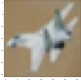

In [ ]:
'''
预测数据
    1、获取测试集中索引为10的图片和标签
    2、展平测试数据
    3、获取预测结果
'''
test_img, test_label = test_dataset[10]

test_img1 = test_img.view(1, -1)
test_img1 = test_img1.cuda()
pred = model(test_img1)
print(class_names[torch.argmax(pred)])

plt.figure(figsize=(10, 10), dpi=10)
B = test_img.numpy()[0,:,:] * 0.2023 + 0.4914
G = test_img.numpy()[1,:,:] * 0.1994 + 0.4822
R = test_img.numpy()[2,:,:] * 0.2010 + 0.4465
RGB= np.stack((R, G, B), axis=-1)
plt.imshow(RGB)